In [26]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import matplotlib.pyplot as plt
import math
import SALib
from scipy.optimize import fsolve
from scipy.constants import N_A

In [27]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*100000000
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [28]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'r_ab', 'koff', 'dummy'],
    'bounds': [[4, 6],
               [4, 6],
               [1e-8, 5e-8],
               [-6, -4],
               [1, 1000]]
}

In [29]:

vals = SALib.sample.sobol.sample(problem1, 65536)
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
Y1 = np.zeros(len(vals))
Y2 = np.zeros(len(vals))
indicies = []
indicies_1 = []
indicies_2 = []
indicies_3= []
indicies_4 = []
indicies_5 = []

In [30]:
16384*16

262144

In [31]:
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
      
        rtot = params[0]
        rtot = 10**rtot
        kon = params[1]
        kon = 10**kon
        r_ab = params[2]
        koff = params[3]
        koff = 10**koff
        dummy = params[4]

        reaction_volume = (2*1e3*math.pi*(r_ab**3))/3
        target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume)
        k2 = target_effective_conc*kon/rtot  
        
        if Ainit < 1e-8:
            guess = 1e-4
        else:
            guess = 1e-4

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag =(A1_st + A2_st)
        Y[i] = Ag
        Y1[i] = Ag/rtot
        Y2[i] = (A1_st + 2*A2_st)/rtot
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])
    Si = sobol.analyze(problem1, Y1, print_to_console=True)
    indicies_2.append(Si['ST'])
    indicies_3.append(Si['S1'])
    Si = sobol.analyze(problem1, Y2, print_to_console=True)
    indicies_4.append(Si['ST'])
    indicies_5.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.777839  0.044407
kon    0.590659  0.034525
r_ab   0.032807  0.002449
koff   0.593537  0.034248
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.139689  0.016257
kon    0.060380  0.011306
r_ab   0.002741  0.002199
koff   0.056849  0.011204
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.190623  0.045999
(rtot, r_ab)   0.002228  0.026693
(rtot, koff)   0.195999  0.041623
(rtot, dummy) -0.001570  0.025977
(kon, r_ab)    0.001460  0.017296
(kon, koff)    0.090562  0.027680
(kon, dummy)  -0.001296  0.016511
(r_ab, koff)   0.001664  0.005894
(r_ab, dummy) -0.000629  0.003953
(koff, dummy)  0.004040  0.018231
             ST   ST_conf
rtot   0.996382  0.009493
kon    0.014218  0.000935
r_ab   0.000667  0.000059
koff   0.014324  0.000954
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.978725  0.011022
kon    0.001094  0.001094
r_ab   0.000037  0.000275
koff   0.001005  0.001235
dummy  0.000000  0.000

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999976  6.993135e-03
kon    0.000040  3.066237e-06
r_ab   0.000003  2.692895e-07
koff   0.000039  2.856144e-06
dummy  0.000000  0.000000e+00
             S1   S1_conf
rtot   0.999946  0.011263
kon    0.000011  0.000070
r_ab   0.000004  0.000019
koff   0.000006  0.000060
dummy  0.000000  0.000000
                         S2   S2_conf
(rtot, kon)    8.271494e-06  0.017706
(rtot, r_ab)  -2.317666e-06  0.017702
(rtot, koff)   1.367198e-05  0.017687
(rtot, dummy) -8.610914e-07  0.017696
(kon, r_ab)   -2.822730e-06  0.000114
(kon, koff)    6.022118e-06  0.000113
(kon, dummy)  -3.043157e-06  0.000114
(r_ab, koff)  -2.647269e-06  0.000025
(r_ab, dummy) -2.899485e-06  0.000025
(koff, dummy)  2.955753e-05  0.000106
             ST   ST_conf
rtot   0.704471  0.010844
kon    0.244102  0.013455
r_ab   0.043129  0.001025
koff   0.243689  0.010814
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.620494  0.020166
kon    0.082190  0.006102
r_ab   0.018

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999983  8.169401e-03
kon    0.000001  6.039019e-08
r_ab   0.000023  3.488998e-07
koff   0.000001  6.423938e-08
dummy  0.000000  0.000000e+00
                 S1   S1_conf
rtot   9.999762e-01  0.012605
kon   -2.627735e-08  0.000011
r_ab   1.592038e-05  0.000061
koff   4.121360e-07  0.000012
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    5.128560e-07  0.019189
(rtot, r_ab)   6.587670e-06  0.019184
(rtot, koff)   1.571989e-07  0.019192
(rtot, dummy) -8.705063e-08  0.019192
(kon, r_ab)    3.705053e-07  0.000019
(kon, koff)    8.010695e-07  0.000019
(kon, dummy)   3.599778e-07  0.000019
(r_ab, koff)  -1.442022e-08  0.000098
(r_ab, dummy) -2.967146e-08  0.000098
(koff, dummy) -4.316859e-07  0.000018
             ST   ST_conf
rtot   0.906332  0.008913
kon    0.006206  0.000287
r_ab   0.119975  0.001979
koff   0.006202  0.000261
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.871528  0.009848
kon    0.00182

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.998585e-01  7.747461e-03
kon    1.042255e-07  5.922444e-09
r_ab   2.116572e-04  3.368012e-06
koff   1.040092e-07  5.295036e-09
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.997883e-01  0.011770
kon   -7.139738e-08  0.000004
r_ab   1.415601e-04  0.000163
koff   5.420116e-08  0.000003
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    1.173927e-07  0.019348
(rtot, r_ab)   7.009875e-05  0.019325
(rtot, koff)   1.796164e-08  0.019348
(rtot, dummy) -2.507060e-08  0.019348
(kon, r_ab)    1.022256e-07  0.000005
(kon, koff)    1.443380e-07  0.000005
(kon, dummy)   1.040938e-07  0.000005
(r_ab, koff)  -3.282816e-08  0.000278
(r_ab, dummy) -3.533950e-08  0.000278
(koff, dummy) -1.141011e-07  0.000005
             ST   ST_conf
rtot   0.910757  0.009459
kon    0.000081  0.000004
r_ab   0.113675  0.001850
koff   0.000081  0.000004
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.886215 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.992149e-01  7.652769e-03
kon    8.624450e-09  4.260272e-10
r_ab   1.334077e-03  2.313226e-05
koff   8.606724e-09  3.874354e-10
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.986661e-01  1.289764e-02
kon   -2.647388e-08  9.108055e-07
r_ab   7.853143e-04  3.858457e-04
koff   1.020810e-08  1.082691e-06
dummy  0.000000e+00  0.000000e+00
                         S2   S2_conf
(rtot, kon)    1.403074e-08  0.019412
(rtot, r_ab)   5.487476e-04  0.019370
(rtot, koff)  -1.452747e-08  0.019412
(rtot, dummy) -2.310740e-08  0.019412
(kon, r_ab)    2.915388e-08  0.000002
(kon, koff)    3.500089e-08  0.000002
(kon, dummy)   3.173142e-08  0.000002
(r_ab, koff)  -7.674092e-08  0.000645
(r_ab, dummy) -7.777142e-08  0.000645
(koff, dummy) -3.366675e-08  0.000002
             ST       ST_conf
rtot   0.912649  7.270119e-03
kon    0.000002  8.153102e-08
r_ab   0.095553  1.197097e-03
koff   0.000002  6.929847e-08
dummy  0.000000  0.00000

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_33557/2358373068.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


Text(0, 0.5, 'Total Order Sobol Indicies')

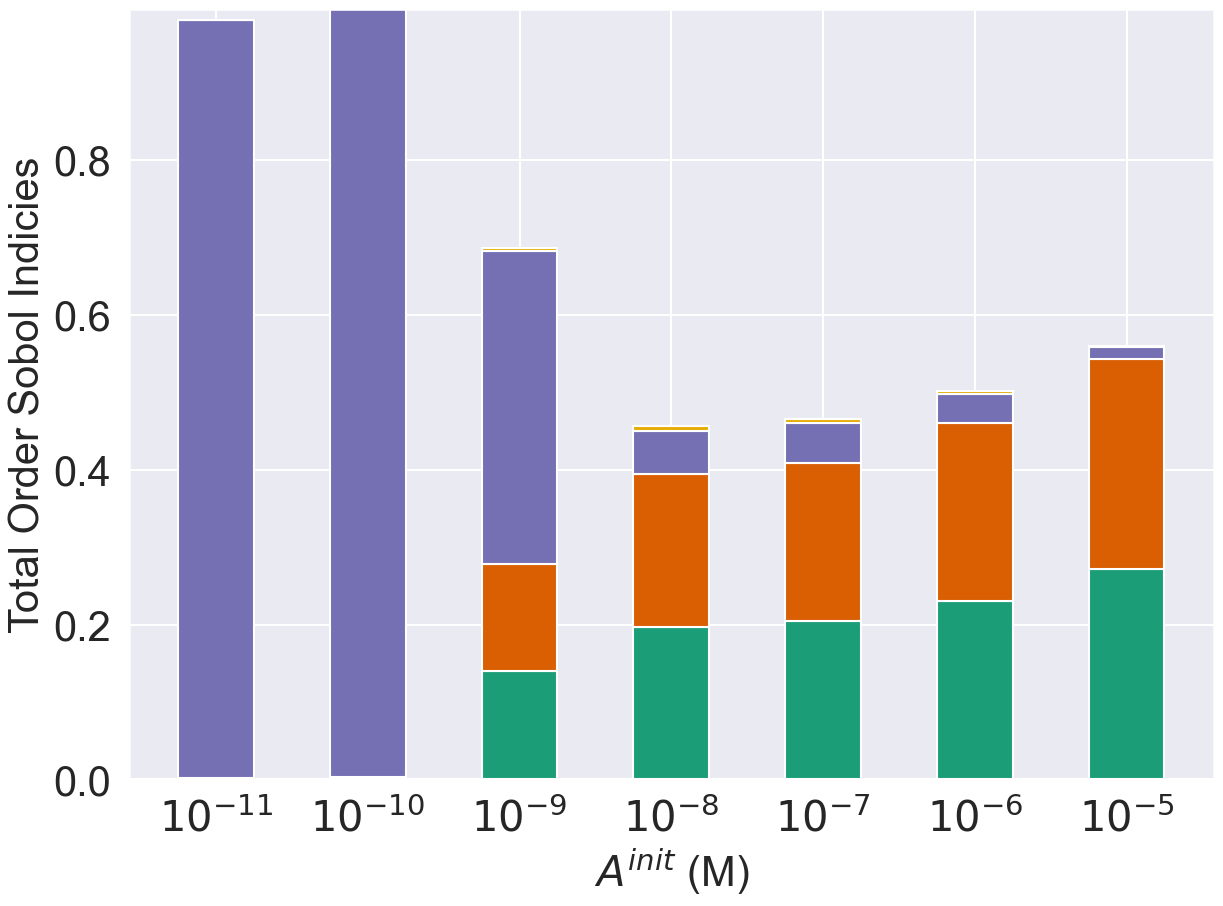

In [36]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
rab_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies_5[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    rab_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(14,10))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, rab_si, width, label=r'$r^{Ab}$', bottom= bottom, color=cm(5))
bottom+= rab_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
#ax.legend(loc='best', fontsize=20)
ax.tick_params(labelsize=30)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=30)
ax.set_ylabel('Total Order Sobol Indicies', fontsize=30)
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_r_receptor_occupancy_total_order_sensiv_analysis.png')

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_33557/504175422.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


Text(0, 0.5, 'First Order Sobol Indicies')

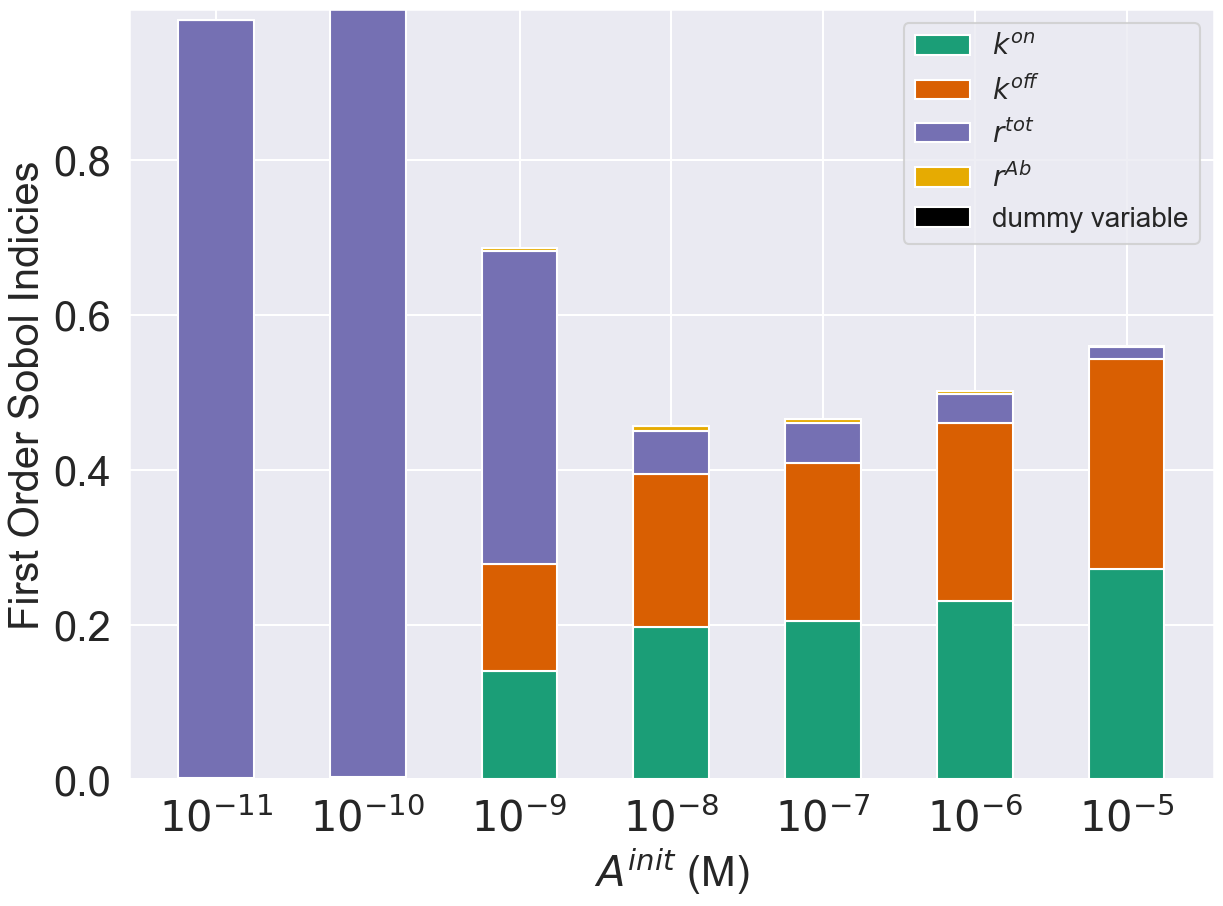

In [33]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
rab_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies)):
    vals = indicies_5[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    rab_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(14,10))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, rab_si, width, label=r'$r^{Ab}$', bottom= bottom, color=cm(5))
bottom+= rab_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best', fontsize=20)
ax.tick_params(labelsize=30)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=30)
ax.set_ylabel('First Order Sobol Indicies', fontsize=30)
#plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_r_receptor_occupancy_first_order_sensiv_analysis.png')